<a href="https://colab.research.google.com/github/uzmabb182/Deep-Learning-Charity-Funding-Predictor/blob/main/charity_funding_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 97 kB 6.9 MB/s 


In [4]:
# Import our dependencies
import sys
sys.path.append('drive/Project')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

In [6]:
# Loading the dataset from the resources folder

charity_df = pd.read_csv(Path('charity_data.csv'))

In [7]:
charity_df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


# Exploratory Data Analysis (EDA):

1. Drop the unnamed column as it does not contribute to clustering or add value to input data
2. List the DataFrame's data types to ensure they're aligned to the type of data stored on each column.
3. Is there any column whose data type need to be changed? If so, make the corresponding adjustments.
4. Is there any unnecessary column that needs to be dropped? If so, make the corresponding adjustments.
5. Check for duplicates.
6. In order to use unsupervised learning algorithms, all the features should be numeric, and also, on similar scales.
7. Rename the column if needed.
8. Check for categorical data in columns.
9. Determine the number of unique values for each column.
10. For those columns that have more than 10 unique values, determine the number of data points for each unique value.
11. Use the number of data points for each unique value to pick a cutoff point to bin "rare" categorical variables together in a new value, Other, and then check if the binning was successful.
12. What variable(s) are considered the target(s) for your model?
13. What variable(s) are considered the feature(s) for your model?

In [8]:
charity_df.shape

(34299, 12)

In [ ]:
charity_df.dtypes

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

In [9]:
# Find null values
for column in charity_df.columns:
    print(f"Column {column} has {charity_df[column].isnull().sum()} null values")


Column EIN has 0 null values
Column NAME has 0 null values
Column APPLICATION_TYPE has 0 null values
Column AFFILIATION has 0 null values
Column CLASSIFICATION has 0 null values
Column USE_CASE has 0 null values
Column ORGANIZATION has 0 null values
Column STATUS has 0 null values
Column INCOME_AMT has 0 null values
Column SPECIAL_CONSIDERATIONS has 0 null values
Column ASK_AMT has 0 null values
Column IS_SUCCESSFUL has 0 null values


In [10]:
# Find duplicate entries
print(f"Duplicate entries: {charity_df.duplicated().sum()}")

Duplicate entries: 0


In [11]:
# A list of the columns from the original DataFrame
charity_df.columns

Index(['EIN', 'NAME', 'APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
       'USE_CASE', 'ORGANIZATION', 'STATUS', 'INCOME_AMT',
       'SPECIAL_CONSIDERATIONS', 'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')

In [12]:
charity_df.columns

Index(['EIN', 'NAME', 'APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
       'USE_CASE', 'ORGANIZATION', 'STATUS', 'INCOME_AMT',
       'SPECIAL_CONSIDERATIONS', 'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')

In [13]:
charity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [14]:
# Function checking for missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [15]:
missing_values_table(charity_df)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Data Preprocessing:

In [16]:
# Drop 'EIN', 'NAME' columns from the dataframe

charity_df = charity_df.drop(['EIN', 'NAME'], axis=1)
charity_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [17]:
charity_df["INCOME_AMT"]

0                    0
1               1-9999
2                    0
3          10000-24999
4        100000-499999
             ...      
34294                0
34295                0
34296                0
34297                0
34298            1M-5M
Name: INCOME_AMT, Length: 34299, dtype: object

In [18]:
# new data frame with split value columns
charity_df[['INCOME_LOWER','INCOME_UPPER']] = charity_df["INCOME_AMT"].str.split("-", n = 1, expand = True)
charity_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,INCOME_LOWER,INCOME_UPPER
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1,0,None
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1,1,9999
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0,0,None
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1,10000,24999
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1,100000,499999
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0,0,None
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0,0,None
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0,0,None
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1,0,None


In [19]:
charity_df = charity_df.fillna(0)
charity_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,INCOME_LOWER,INCOME_UPPER
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1,0,0
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1,1,9999
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0,0,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1,10000,24999
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1,100000,499999
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0,0,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0,0,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0,0,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1,0,0


In [21]:
charity_df['INCOME_UPPER'] = charity_df['INCOME_UPPER'].replace('M','', regex=True)
charity_df['INCOME_LOWER'] = charity_df['INCOME_LOWER'].replace('M','', regex=True)



In [22]:
charity_df["INCOME_LOWER"] 
charity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34299 non-null  object
 1   AFFILIATION             34299 non-null  object
 2   CLASSIFICATION          34299 non-null  object
 3   USE_CASE                34299 non-null  object
 4   ORGANIZATION            34299 non-null  object
 5   STATUS                  34299 non-null  int64 
 6   INCOME_AMT              34299 non-null  object
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object
 8   ASK_AMT                 34299 non-null  int64 
 9   IS_SUCCESSFUL           34299 non-null  int64 
 10  INCOME_LOWER            34299 non-null  object
 11  INCOME_UPPER            34299 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.1+ MB


In [23]:
charity_df["INCOME_LOWER"] = charity_df["INCOME_LOWER"].str.strip()
charity_df["INCOME_UPPER"] = charity_df["INCOME_UPPER"].str.strip()


In [24]:
charity_df['INCOME_LOWER'] = charity_df['INCOME_LOWER'].replace('\+','', regex=True)
charity_df['INCOME_UPPER'] = charity_df['INCOME_UPPER'].replace('\+','', regex=True)

In [25]:
charity_df["INCOME_LOWER"].convert_dtypes().dtypes
charity_df["INCOME_UPPER"].convert_dtypes().dtypes
charity_df[["INCOME_LOWER", "INCOME_UPPER"]] = charity_df[["INCOME_LOWER", "INCOME_UPPER"]].apply(pd.to_numeric)

charity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   APPLICATION_TYPE        34299 non-null  object 
 1   AFFILIATION             34299 non-null  object 
 2   CLASSIFICATION          34299 non-null  object 
 3   USE_CASE                34299 non-null  object 
 4   ORGANIZATION            34299 non-null  object 
 5   STATUS                  34299 non-null  int64  
 6   INCOME_AMT              34299 non-null  object 
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object 
 8   ASK_AMT                 34299 non-null  int64  
 9   IS_SUCCESSFUL           34299 non-null  int64  
 10  INCOME_LOWER            34299 non-null  int64  
 11  INCOME_UPPER            9772 non-null   float64
dtypes: float64(1), int64(4), object(7)
memory usage: 3.1+ MB


In [26]:
charity_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,INCOME_LOWER,INCOME_UPPER
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1,0,NaN
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1,1,9999.0
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0,0,NaN
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1,10000,24999.0
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1,100000,499999.0
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0,0,NaN
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0,0,NaN
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0,0,NaN
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1,0,NaN


In [27]:
# Drop 'INCOME_AMT' columns from the dataframe

charity_df = charity_df.drop(['INCOME_AMT'], axis=1)
charity_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,INCOME_LOWER,INCOME_UPPER
0,T10,Independent,C1000,ProductDev,Association,1,N,5000,1,0,NaN
1,T3,Independent,C2000,Preservation,Co-operative,1,N,108590,1,1,9999.0
2,T5,CompanySponsored,C3000,ProductDev,Association,1,N,5000,0,0,NaN
3,T3,CompanySponsored,C2000,Preservation,Trust,1,N,6692,1,10000,24999.0
4,T3,Independent,C1000,Heathcare,Trust,1,N,142590,1,100000,499999.0
...,...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,N,5000,0,0,NaN
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,N,5000,0,0,NaN
34296,T3,CompanySponsored,C2000,Preservation,Association,1,N,5000,0,0,NaN
34297,T5,Independent,C3000,ProductDev,Association,1,N,5000,1,0,NaN


In [28]:
# Generate our categorical variable lists
charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()
# Check the number of unique values in each column
charity_df[charity_cat].nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [29]:
# Look at APPLICATION_TYPE value counts for binning

charity_df["APPLICATION_TYPE"].value_counts() 

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [30]:
application_types_to_replace = ['T9', 'T13', 'T12', 'T2', 'T14', 'T25', 'T29', 'T15', 'T17']

In [31]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`

application_types_to_replace = ['T9', 'T13', 'T12', 'T2', 'T14', 'T25', 'T29', 'T15', 'T17']

# Replace in dataframe
for app in application_types_to_replace:
    charity_df['APPLICATION_TYPE'] = charity_df['APPLICATION_TYPE'].replace(app,"Other")
    
# Check to make sure binning was successful
charity_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [32]:
# Look at CLASSIFICATION value counts for binning

my_value_count = charity_df["CLASSIFICATION"].value_counts()
# a_list[0]
my_value_count.index
my_value_count

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C8210        1
C3700        1
C2561        1
C1236        1
C1245        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [33]:
# Getting the values that need to be binned in 'classifications_to_replace'
my_value_count = my_value_count.loc[~my_value_count.index.isin(['C1000', 'C2000', 'C1200', 'C3000', 'C2100'])]
my_value_count.index
classifications_to_replace = my_value_count.index.tolist()
classifications_to_replace

['C7000',
 'C1700',
 'C4000',
 'C5000',
 'C1270',
 'C2700',
 'C2800',
 'C7100',
 'C1300',
 'C1280',
 'C1230',
 'C1400',
 'C7200',
 'C2300',
 'C1240',
 'C8000',
 'C7120',
 'C1500',
 'C1800',
 'C6000',
 'C1250',
 'C8200',
 'C1238',
 'C1278',
 'C1235',
 'C1237',
 'C7210',
 'C1720',
 'C2400',
 'C4100',
 'C1600',
 'C1257',
 'C2710',
 'C0',
 'C1260',
 'C3200',
 'C1267',
 'C1246',
 'C1256',
 'C1234',
 'C1732',
 'C6100',
 'C1580',
 'C1900',
 'C2150',
 'C4500',
 'C4200',
 'C5200',
 'C2170',
 'C2380',
 'C1248',
 'C2500',
 'C4120',
 'C1370',
 'C1728',
 'C2190',
 'C1820',
 'C2570',
 'C1283',
 'C2600',
 'C1570',
 'C8210',
 'C3700',
 'C2561',
 'C1236',
 'C1245']

In [34]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`

# Replace in dataframe
for cls in classifications_to_replace:
    charity_df['CLASSIFICATION'] = charity_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
charity_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [35]:
# # Create a OneHotEncoder instance
# enc = OneHotEncoder(sparse=False)

# # Fit and transform the OneHotEncoder using the categorical variable list
# encode_df = pd.DataFrame(enc.fit_transform(charity_df[charity_cat]))

# # Add the encoded variable names to the dataframe
# encode_df.columns = enc.get_feature_names(charity_cat)
# encode_df.head()

In [36]:
# # Merge one-hot encoded features and drop the originals
# charity_df = charity_df.merge(encode_df,left_index=True, right_index=True)
# charity_df = charity_df.drop(charity_cat,1)
# charity_df.head()

In [37]:
charity_df['INCOME_LOWER'] = charity_df['INCOME_LOWER'].fillna(0)
charity_df['INCOME_UPPER'] = charity_df['INCOME_UPPER'].fillna(0)

In [38]:
# Save as a csv to check the values of 'others' category
# Note to avoid any issues later, use encoding="utf-8"
charity_df.to_csv("check_df.csv", encoding="utf-8", index=False)

In [39]:
# Generate our categorical variable lists
charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()

In [40]:
# Check the number of unique values in each column
# charity_df[charity_cat].nunique()

In [41]:
# charity_df[charity_cat].info()
# charity_df[charity_cat]
charity_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,INCOME_LOWER,INCOME_UPPER
0,T10,Independent,C1000,ProductDev,Association,1,N,5000,1,0,0.0
1,T3,Independent,C2000,Preservation,Co-operative,1,N,108590,1,1,9999.0
2,T5,CompanySponsored,C3000,ProductDev,Association,1,N,5000,0,0,0.0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,N,6692,1,10000,24999.0
4,T3,Independent,C1000,Heathcare,Trust,1,N,142590,1,100000,499999.0
...,...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,N,5000,0,0,0.0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,N,5000,0,0,0.0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,N,5000,0,0,0.0
34297,T5,Independent,C3000,ProductDev,Association,1,N,5000,1,0,0.0


In [42]:
charity_df.dtypes

APPLICATION_TYPE           object
AFFILIATION                object
CLASSIFICATION             object
USE_CASE                   object
ORGANIZATION               object
STATUS                      int64
SPECIAL_CONSIDERATIONS     object
ASK_AMT                     int64
IS_SUCCESSFUL               int64
INCOME_LOWER                int64
INCOME_UPPER              float64
dtype: object

In [43]:
# Drop the class column
X = charity_df.drop(["IS_SUCCESSFUL"], axis='columns')
X.head()


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,INCOME_LOWER,INCOME_UPPER
0,T10,Independent,C1000,ProductDev,Association,1,N,5000,0,0.0
1,T3,Independent,C2000,Preservation,Co-operative,1,N,108590,1,9999.0
2,T5,CompanySponsored,C3000,ProductDev,Association,1,N,5000,0,0.0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,N,6692,10000,24999.0
4,T3,Independent,C1000,Heathcare,Trust,1,N,142590,100000,499999.0


In [44]:
y = charity_df["IS_SUCCESSFUL"]
y

0        1
1        1
2        0
3        1
4        1
        ..
34294    0
34295    0
34296    0
34297    1
34298    0
Name: IS_SUCCESSFUL, Length: 34299, dtype: int64

In [45]:
# convert the remaining features with text values, Algorithm and ProofType, into numerical data
X_dummies = pd.get_dummies(X)
print (X_dummies.columns)
X_dummies

Index(['STATUS', 'ASK_AMT', 'INCOME_LOWER', 'INCOME_UPPER',
       'APPLICATION_TYPE_Other', 'APPLICATION_TYPE_T10',
       'APPLICATION_TYPE_T19', 'APPLICATION_TYPE_T3', 'APPLICATION_TYPE_T4',
       'APPLICATION_TYPE_T5', 'APPLICATION_TYPE_T6', 'APPLICATION_TYPE_T7',
       'APPLICATION_TYPE_T8', 'AFFILIATION_CompanySponsored',
       'AFFILIATION_Family/Parent', 'AFFILIATION_Independent',
       'AFFILIATION_National', 'AFFILIATION_Other', 'AFFILIATION_Regional',
       'CLASSIFICATION_C1000', 'CLASSIFICATION_C1200', 'CLASSIFICATION_C2000',
       'CLASSIFICATION_C2100', 'CLASSIFICATION_C3000', 'CLASSIFICATION_Other',
       'USE_CASE_CommunityServ', 'USE_CASE_Heathcare', 'USE_CASE_Other',
       'USE_CASE_Preservation', 'USE_CASE_ProductDev',
       'ORGANIZATION_Association', 'ORGANIZATION_Co-operative',
       'ORGANIZATION_Corporation', 'ORGANIZATION_Trust',
       'SPECIAL_CONSIDERATIONS_N', 'SPECIAL_CONSIDERATIONS_Y'],
      dtype='object')


,STATUS,ASK_AMT,INCOME_LOWER,INCOME_UPPER,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,1,108590,1,9999.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0
2,1,5000,0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
3,1,6692,10000,24999.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
4,1,142590,100000,499999.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,1,5000,0,0.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
34295,1,5000,0,0.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
34296,1,5000,0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0
34297,1,5000,0,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0


In [46]:
print (len(X_dummies.columns))


36


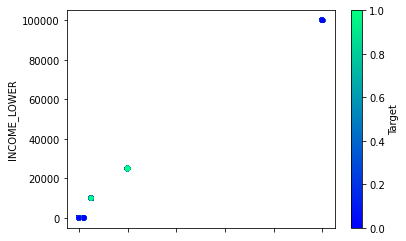

In [47]:
# Creating a DataFrame
df = pd.DataFrame(X_dummies, columns=["INCOME_UPPER", "INCOME_LOWER"])
df["Target"] = y

# Plotting the dummy data
df.plot.scatter(x="INCOME_UPPER", y="INCOME_LOWER", c="Target", colormap="winter")

In [48]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, random_state=78)

In [49]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)



# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model:

In [50]:
# Define the model - deep neural net
number_input_features = len(X_dummies.columns)
hidden_nodes_layer1 =  10


In [51]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

In [52]:
# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

In [53]:
# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [54]:
# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                370       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
# Train the model
# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.6346 - accuracy: 0.6858
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5723 - accuracy: 0.7181
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5674 - accuracy: 0.7222
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5652 - accuracy: 0.7231
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5641 - accuracy: 0.7249
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5629 - accuracy: 0.7248
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5621 - accuracy: 0.7250
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5616 - accuracy: 0.7264
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5608 - accuracy: 0.7260
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5606 - accura

In [57]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5542 - accuracy: 0.7257
Loss: 0.5541560053825378, Accuracy: 0.7257142663002014


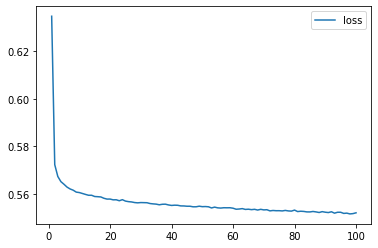

In [58]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

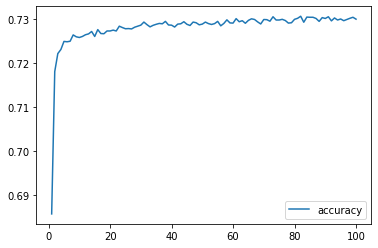

In [59]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

In [189]:
# Export our model to HDF5 file

# nn_model.save("drive/Project/AlphabetSoupCharity.h5")

In [190]:
## Optimizing the Model:

In [191]:
# # Import the kerastuner library
# import kerastuner as kt

# tuner = kt.Hyperband(
#     nn_model,
#     objective="val_accuracy",
#     max_epochs=100,
#     hyperband_iterations=2)

In [192]:
# # Run the kerastuner search for best hyperparameters
# tuner.search(X_train_scaled,y_train,epochs=100,validation_data=(X_test_scaled,y_test))

In [193]:
# # Get best model hyperparameters
# best_hyper = tuner.get_best_hyperparameters(1)[0]
# best_hyper.values

In [194]:
# # Evaluate best model against full test data
# best_model = tuner.get_best_models(1)[0]
# model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [61]:
# Optimization Hyperparameter tunning:
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5


In [62]:
# Create a new neural network model with 4 neurons
nn_model2 = tf.keras.models.Sequential()

nn_model2.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

nn_model2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn_model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit_model = nn_model2.fit(X_train_scaled, y_train, epochs=100)


Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.6452 - accuracy: 0.6792
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5802 - accuracy: 0.7196
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5697 - accuracy: 0.7226
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5662 - accuracy: 0.7228
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5649 - accuracy: 0.7238
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5641 - accuracy: 0.7241
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5631 - accuracy: 0.7240
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5626 - accuracy: 0.7248
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5620 - accuracy: 0.7247
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5618 - accura

In [63]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5573 - accuracy: 0.7236
Loss: 0.5573488473892212, Accuracy: 0.7236151695251465


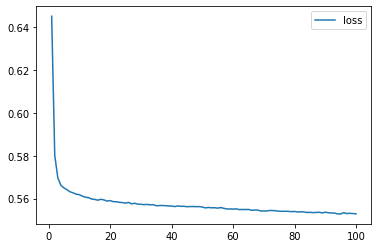

In [64]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

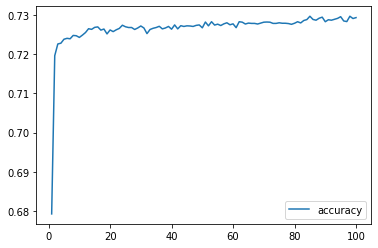

In [65]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

In [66]:
# Create a new neural network model with 6 neurons
nn_model3 = tf.keras.models.Sequential()

nn_model3.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))
nn_model3.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
nn_model3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn_model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit_model = nn_model3.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.6041 - accuracy: 0.6977
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5710 - accuracy: 0.7198
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5654 - accuracy: 0.7204
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5639 - accuracy: 0.7210
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5625 - accuracy: 0.7215
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5613 - accuracy: 0.7223
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5602 - accuracy: 0.7227
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5597 - accuracy: 0.7233
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5588 - accuracy: 0.7237
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5585 - accura

In [72]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5534 - accuracy: 0.7278
Loss: 0.5533725023269653, Accuracy: 0.7278134226799011


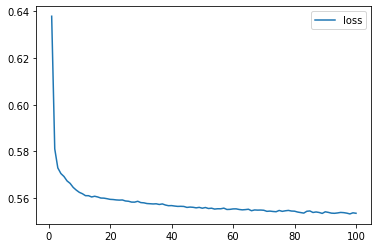

In [73]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

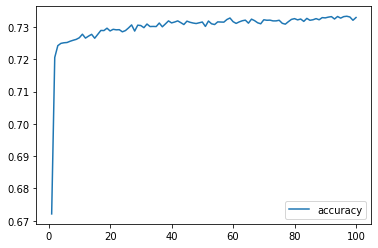

In [74]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

In [75]:
# Optimization Hyperparameter tunning:
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5
hidden_nodes_layer3 = 3

In [79]:
# Create a new neural network model with 6 neurons
nn_model4 = tf.keras.models.Sequential()

nn_model4.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))
nn_model4.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn_model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit_model = nn_model4.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.6139 - accuracy: 0.6665
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5720 - accuracy: 0.7232
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5650 - accuracy: 0.7248
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5621 - accuracy: 0.7257
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5603 - accuracy: 0.7253
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5594 - accuracy: 0.7266
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5588 - accuracy: 0.7269
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5578 - accuracy: 0.7273
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5582 - accuracy: 0.7275
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5576 - accura

In [80]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5546 - accuracy: 0.7271
Loss: 0.5546085834503174, Accuracy: 0.7271137237548828


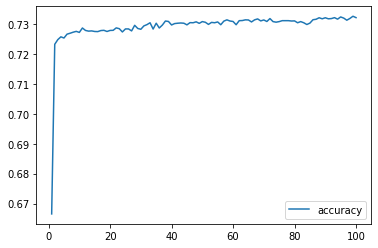

In [81]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

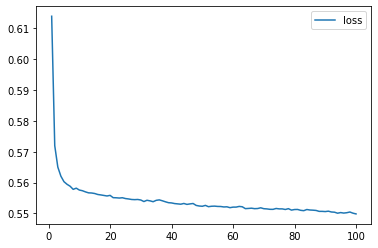

In [82]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")